In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
from glob import glob 

import pandas as pd

from fastcore.xtras import load_pickle

from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

import matplotlib.pyplot as plt 
plt.style.use(['science', 'nature'])

## Load results

In [121]:
all_out = glob("out/**/*.pkl")

In [122]:
all_out = [load_pickle(p) for p in all_out]

In [123]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out: 
    res = {
        'train_size': out['train_size'],
        'frac_valid': out['frac_valid'],
        'accuracy': out['accuracy'],
        'f1_macro': out['f1_macro'],
        'f1_micro': out['f1_micro'],
        'kappa': out['kappa'],
        "num_classes": out['num_classes']
    }

    xgb_res = {
        'train_size': out['train_size'], 
        'accuracy': out['xgboost_baseline']['accuracy'], 
        'f1_macro': out['xgboost_baseline']['f1_macro'],
        'f1_micro': out['xgboost_baseline']['f1_micro'],
        'kappa': out['xgboost_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    tabpfn_res = {
        'train_size': out['train_size'], 
        'accuracy': out['tabpfn_baseline']['accuracy'], 
        'f1_macro': out['tabpfn_baseline']['f1_macro'],
        'f1_micro': out['tabpfn_baseline']['f1_micro'],
        'kappa': out['tabpfn_baseline']['kappa'],
        "num_classes": out['num_classes']
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [124]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [125]:
grouped_res = res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [126]:
grouped_xgboost_res = xgboost_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [127]:
grouped_tabpfn_res = tabpfn_res.groupby(['num_classes', 'train_size']).agg(['mean', 'std'])

In [128]:
grouped_res.loc[2,:]

frac_valid      accuracy            f1_macro           f1_micro  \
                 mean  std     mean       std      mean       std     mean   
train_size                                                                   
10                1.0  0.0    0.580  0.011314  0.542323  0.015687    0.580   
20                1.0  0.0    0.664  0.062225  0.642244  0.091074    0.664   
50                1.0  0.0    0.768  0.022627  0.767428  0.023261    0.768   
100               1.0  0.0    0.912  0.011314  0.911846  0.011524    0.912   
200               1.0  0.0    0.926  0.002828  0.925995  0.002836    0.926   
500               1.0  0.0    0.932  0.011314  0.931958  0.011339    0.932   

                      kappa            
                 std   mean       std  
train_size                             
10          0.011314  0.160  0.022627  
20          0.062225  0.328  0.124451  
50          0.022627  0.536  0.045255  
100         0.011314  0.824  0.022627  
200         0.002828  0.852  0.005657  
500         0.011314  0.864  0.022627

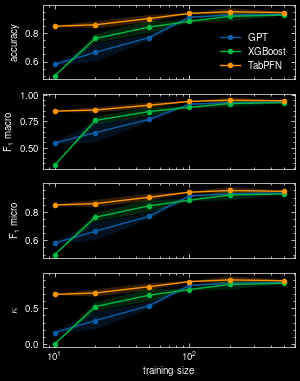

In [129]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex='all')

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[2,:].index,
        grouped_res.loc[2,:][metric]['mean'],
        marker='o',
        label='GPT',
    )
    ax[i].fill_between(
        grouped_res.loc[2,:].index,
        grouped_res.loc[2,:][metric]['mean'] - grouped_res.loc[2,:][metric]['std'],
        grouped_res.loc[2,:][metric]['mean'] + grouped_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'],
        marker='o',
        label='XGBoost'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2,:].index,
        grouped_xgboost_res.loc[2,:][metric]['mean'] - grouped_xgboost_res.loc[2,:][metric]['std'],
        grouped_xgboost_res.loc[2,:][metric]['mean'] + grouped_xgboost_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2,:].index,
        grouped_tabpfn_res.loc[2,:][metric]['mean'] - grouped_tabpfn_res.loc[2,:][metric]['std'],
        grouped_tabpfn_res.loc[2,:][metric]['mean'] + grouped_tabpfn_res.loc[2,:][metric]['std'],
        alpha=0.2,
    )

ax[-1].set_xlabel('training size')
ax[0].legend()

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')

ax[0].set_xscale('log')

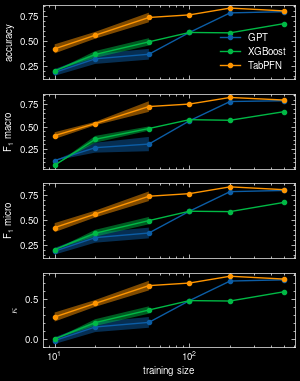

In [130]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex='all')

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
    ax[i].plot(
        grouped_res.loc[5,:].index,
        grouped_res.loc[5,:][metric]['mean'],
        marker='o',
        label='GPT',
    )
    ax[i].fill_between(
        grouped_res.loc[5,:].index,
        grouped_res.loc[5,:][metric]['mean'] - grouped_res.loc[5,:][metric]['std'],
        grouped_res.loc[5,:][metric]['mean'] + grouped_res.loc[5,:][metric]['std'],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'],
        marker='o',
        label='XGBoost'
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5,:].index,
        grouped_xgboost_res.loc[5,:][metric]['mean'] - grouped_xgboost_res.loc[5,:][metric]['std'],
        grouped_xgboost_res.loc[5,:][metric]['mean'] + grouped_xgboost_res.loc[5,:][metric]['std'],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'],
        marker='o',
        label='TabPFN'
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5,:].index,
        grouped_tabpfn_res.loc[5,:][metric]['mean'] - grouped_tabpfn_res.loc[5,:][metric]['std'],
        grouped_tabpfn_res.loc[5,:][metric]['mean'] + grouped_tabpfn_res.loc[5,:][metric]['std'],
        alpha=0.5,
    )

ax[-1].set_xlabel('training size')
ax[0].legend()

ax[0].set_ylabel('accuracy')
ax[1].set_ylabel(r'F$_{1}$ macro')
ax[2].set_ylabel(r'F$_{1}$ micro')
ax[3].set_ylabel(r'$\kappa$')
ax[0].set_xscale('log')